In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, RFE, f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from collections import Counter
from scikeras.wrappers import KerasClassifier
from scipy.stats import zscore, mstats
import warnings
import kagglehub

from kagglehub import KaggleDatasetAdapter
# Set the path to the file you'd like to load
file_path = "data.csv"

data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/breast-cancer-wisconsin-data",
  file_path,
)

# Data Exploration

In [2]:
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

We can see that there is a column (Unnamed: 32) that contains only null values so it should be droped

In [4]:
data.drop(["Unnamed: 32", "id"], axis=1, inplace=True)

And to make the data analysis easier we will convert the diagnosis values to binary
* Benignant(B) - 0
* Malignant(M) - 1

In [5]:
for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
        col_min = data[column].min()
        col_max = data[column].max()
        print(f"{column}: {col_min} - {col_max}")
    else:
        print(f"{column}: non-numeric")


diagnosis: non-numeric
radius_mean: 6.981 - 28.11
texture_mean: 9.71 - 39.28
perimeter_mean: 43.79 - 188.5
area_mean: 143.5 - 2501.0
smoothness_mean: 0.05263 - 0.1634
compactness_mean: 0.01938 - 0.3454
concavity_mean: 0.0 - 0.4268
concave points_mean: 0.0 - 0.2012
symmetry_mean: 0.106 - 0.304
fractal_dimension_mean: 0.04996 - 0.09744
radius_se: 0.1115 - 2.873
texture_se: 0.3602 - 4.885
perimeter_se: 0.757 - 21.98
area_se: 6.802 - 542.2
smoothness_se: 0.001713 - 0.03113
compactness_se: 0.002252 - 0.1354
concavity_se: 0.0 - 0.396
concave points_se: 0.0 - 0.05279
symmetry_se: 0.007882 - 0.07895
fractal_dimension_se: 0.0008948 - 0.02984
radius_worst: 7.93 - 36.04
texture_worst: 12.02 - 49.54
perimeter_worst: 50.41 - 251.2
area_worst: 185.2 - 4254.0
smoothness_worst: 0.07117 - 0.2226
compactness_worst: 0.02729 - 1.058
concavity_worst: 0.0 - 1.252
concave points_worst: 0.0 - 0.291
symmetry_worst: 0.1565 - 0.6638
fractal_dimension_worst: 0.05504 - 0.2075


In [6]:
data["diagnosis"].replace(to_replace={"M":1,"B":0},inplace=True)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


There is an ID column (1), label column (2), 10 different features each mesured with 3 different forms (10 x 3)

In [7]:
# Dynamic grouping based on suffix
mean_features = [col for col in data.columns if col.endswith('_mean')]
se_features = [col for col in data.columns if col.endswith('_se')]
worst_features = [col for col in data.columns if col.endswith('_worst')]

print("Mean Features:", mean_features)
print("Standard Error (SE) Features:", se_features)
print("Worst Features:", worst_features)

Mean Features: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
Standard Error (SE) Features: ['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']
Worst Features: ['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


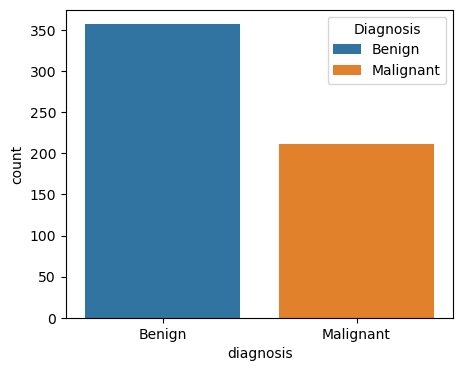

In [8]:
plt.figure(figsize=(5,4))
sns.countplot(x="diagnosis", data=data, hue="diagnosis")
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.legend(title='Diagnosis', labels=['Benign', 'Malignant'])
plt.show()

<Axes: >

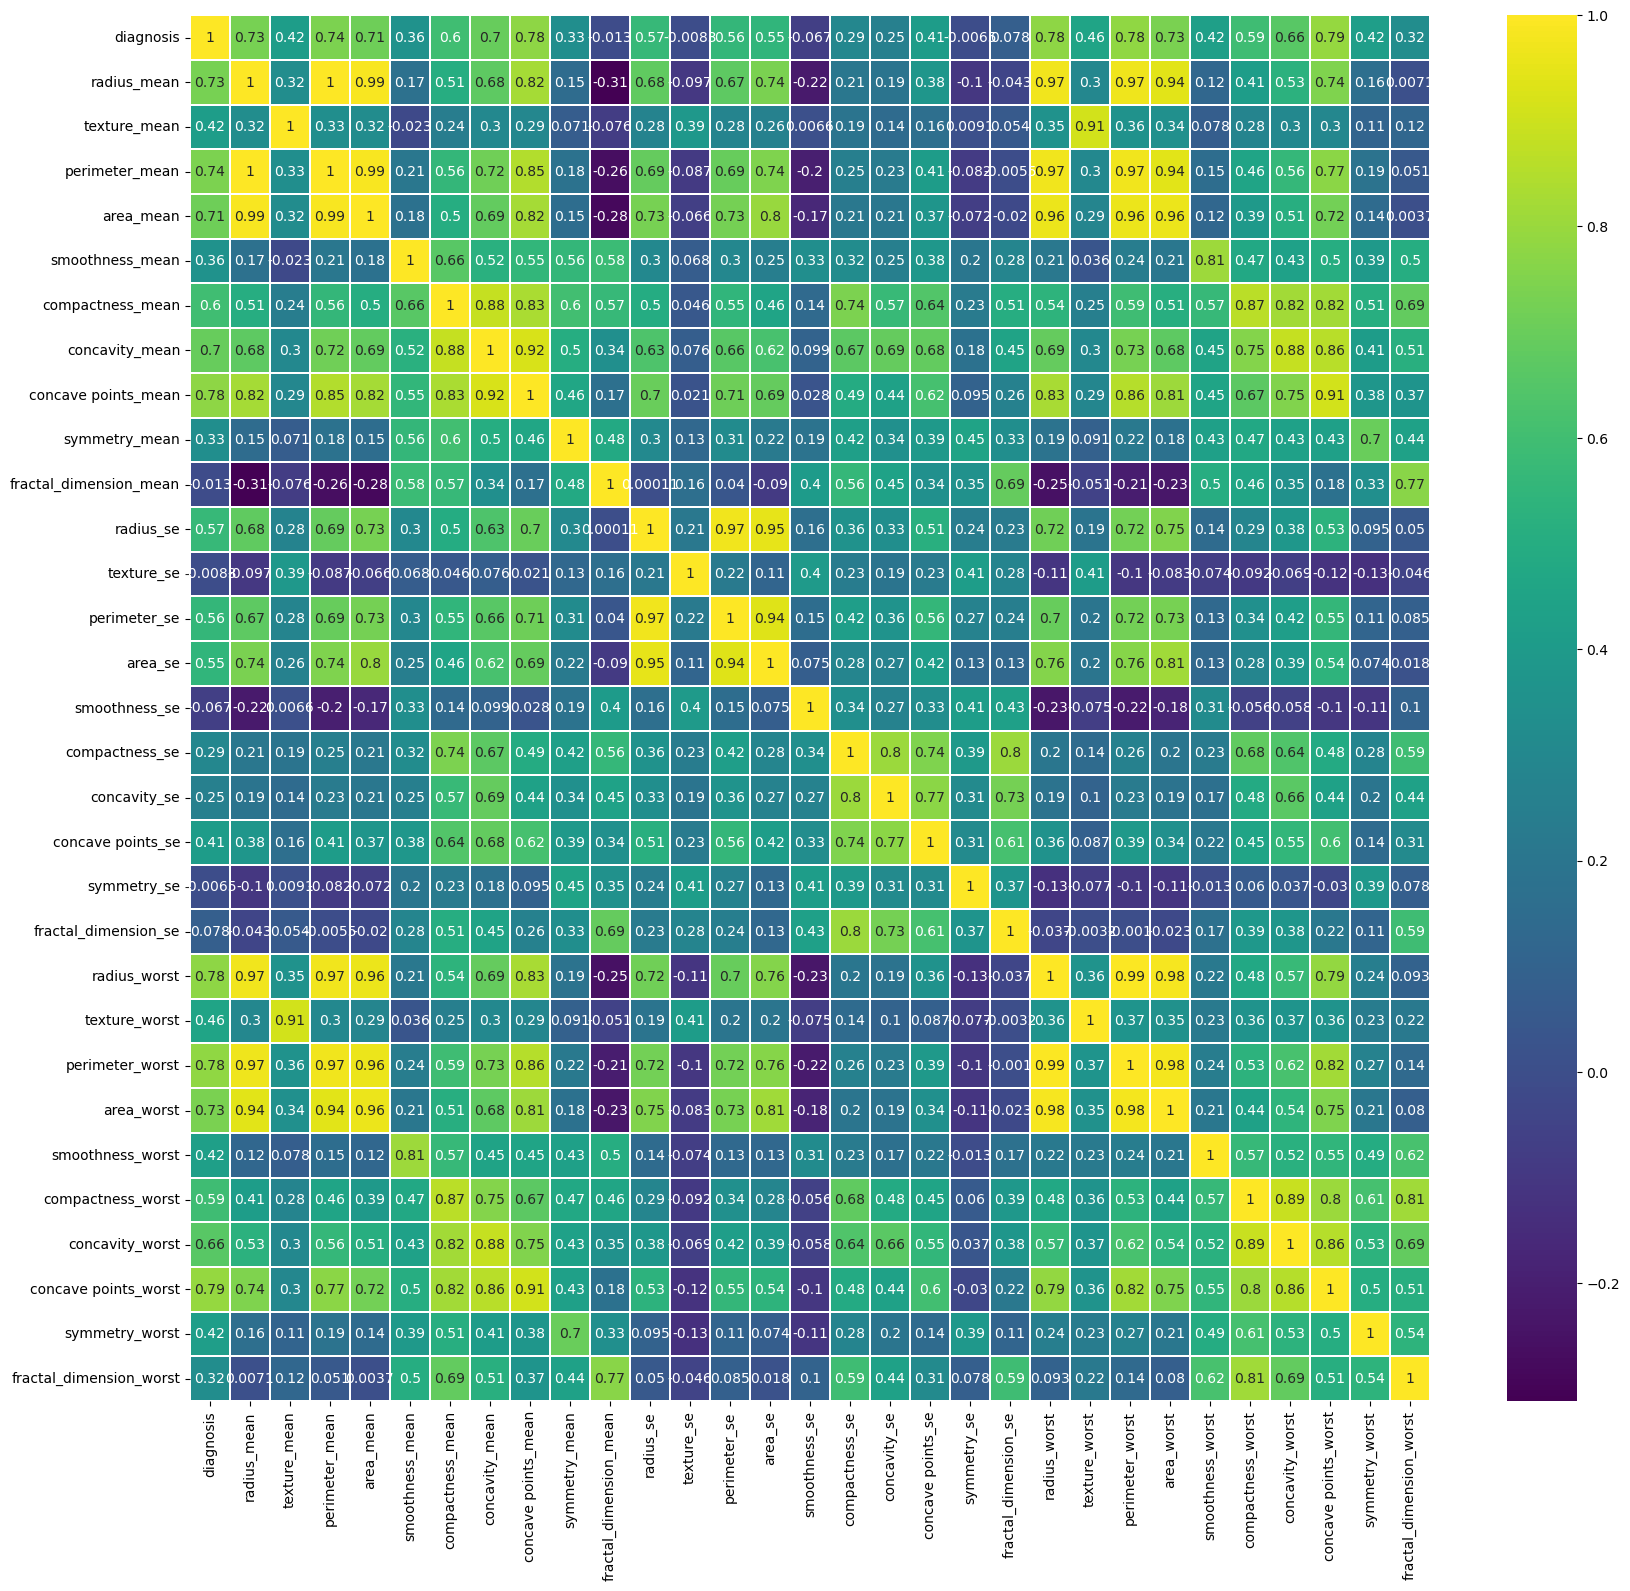

In [9]:
plt.figure(figsize=(20,18))
sns.heatmap(data.corr(), annot=True,linewidths=.3, cmap="viridis")

For the heatmap to be more usefull, we can use a threshhold

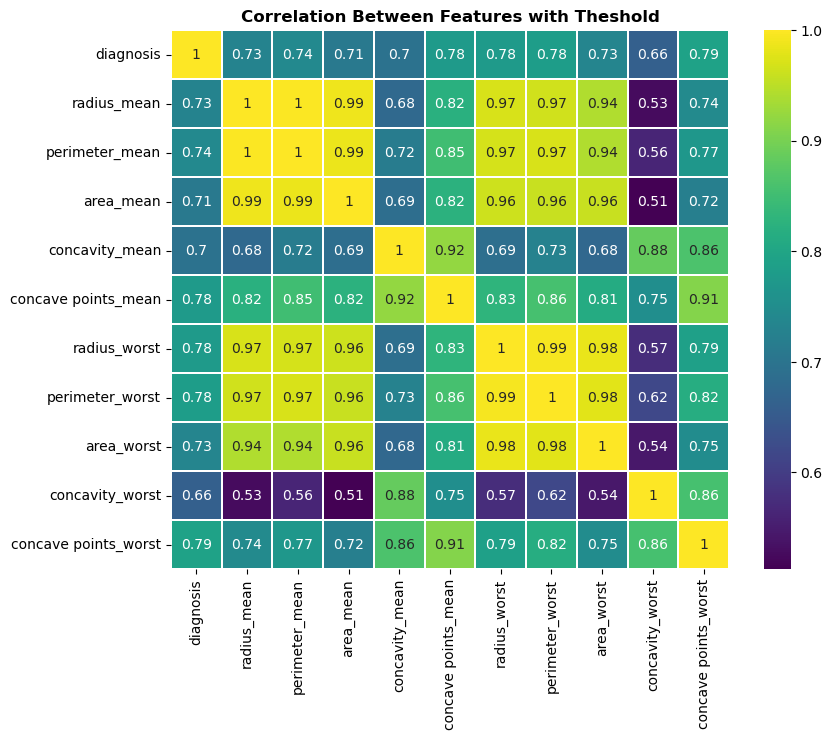

In [10]:
corr = data.corr()
threshold = 0.6
filtre = np.abs(corr["diagnosis"]) > threshold
corr_features = corr.columns[filtre].tolist()

plt.figure(figsize=(9,7))
sns.heatmap(data[corr_features].corr(), annot = True, cmap="viridis", linewidths=0.1,)
plt.title("Correlation Between Features with Theshold", fontweight = "bold")

plt.show()

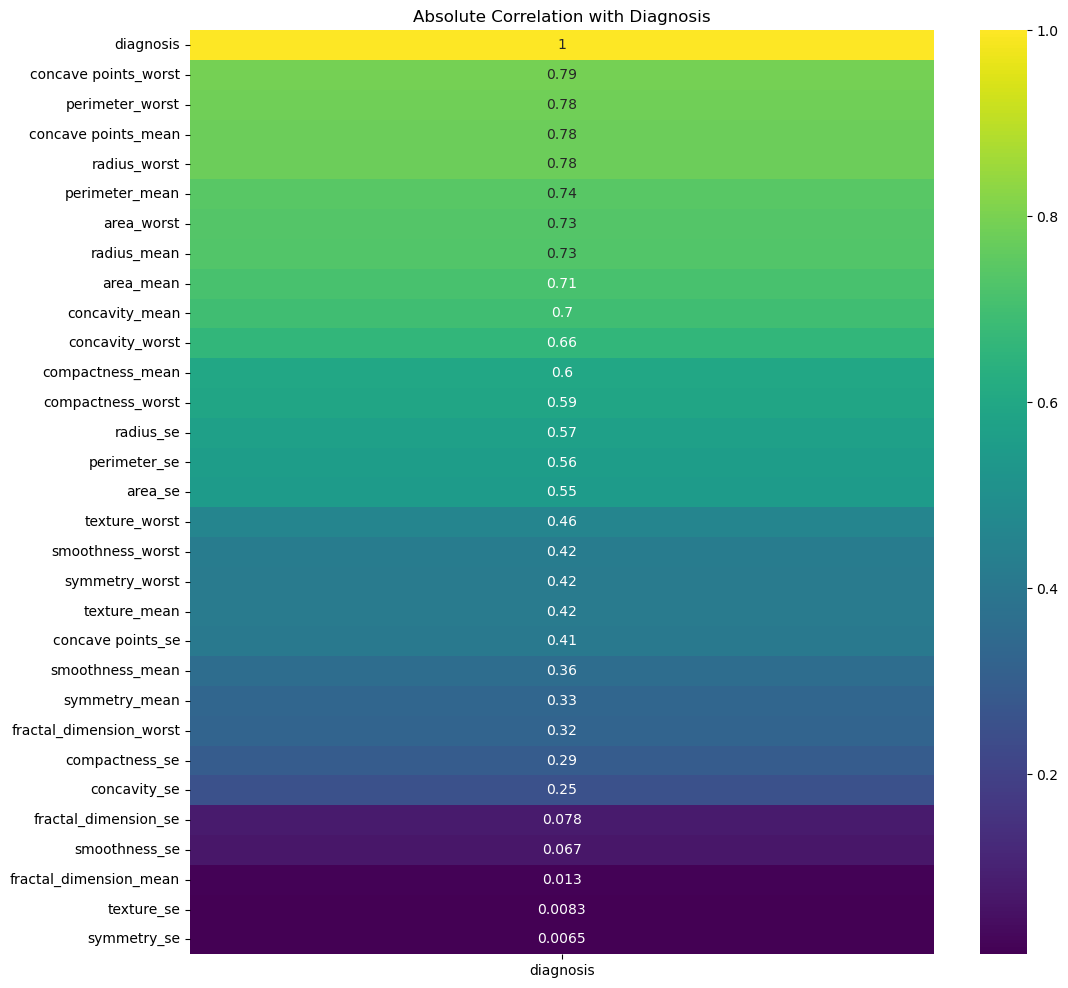

In [11]:
plt.figure(figsize=(12, 12))
correlation = data.corr()
sns.heatmap(correlation[['diagnosis']].abs().sort_values(by='diagnosis', ascending=False), annot=True, cmap="viridis")
plt.title("Absolute Correlation with Diagnosis")
plt.show()

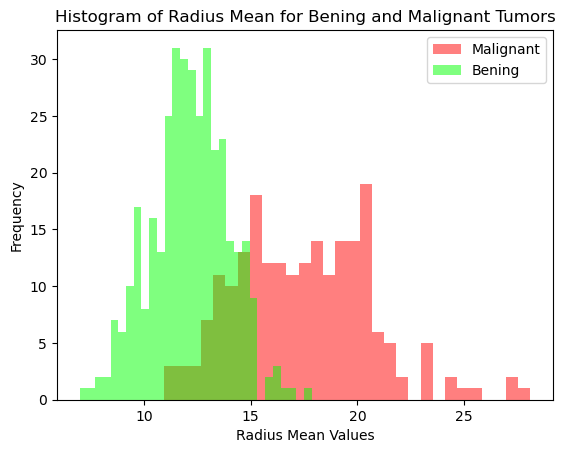

In [12]:
m = plt.hist(data[data["diagnosis"] == 1].radius_mean,bins=30,fc = (1,0,0,0.5),label = "Malignant")
b = plt.hist(data[data["diagnosis"] == 0].radius_mean,bins=30,fc = (0,1,0,0.5),label = "Bening")
plt.legend()
plt.xlabel("Radius Mean Values")
plt.ylabel("Frequency")
plt.title("Histogram of Radius Mean for Bening and Malignant Tumors")
plt.show()


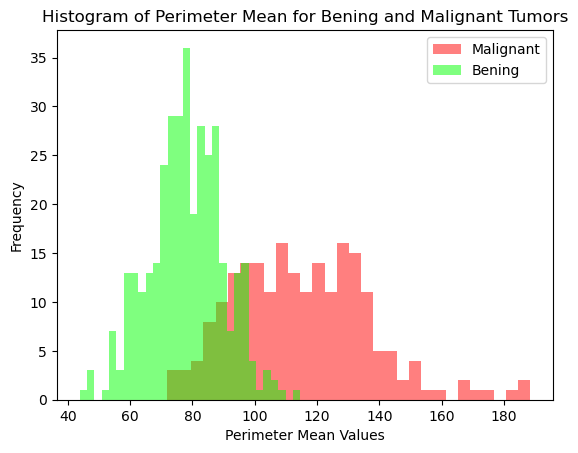

In [13]:
m = plt.hist(data[data["diagnosis"] == 1].perimeter_mean,bins=30,fc = (1,0,0,0.5),label = "Malignant")
b = plt.hist(data[data["diagnosis"] == 0].perimeter_mean,bins=30,fc = (0,1,0,0.5),label = "Bening")
plt.legend()
plt.xlabel("Perimeter Mean Values")
plt.ylabel("Frequency")
plt.title("Histogram of Perimeter Mean for Bening and Malignant Tumors")
plt.show()


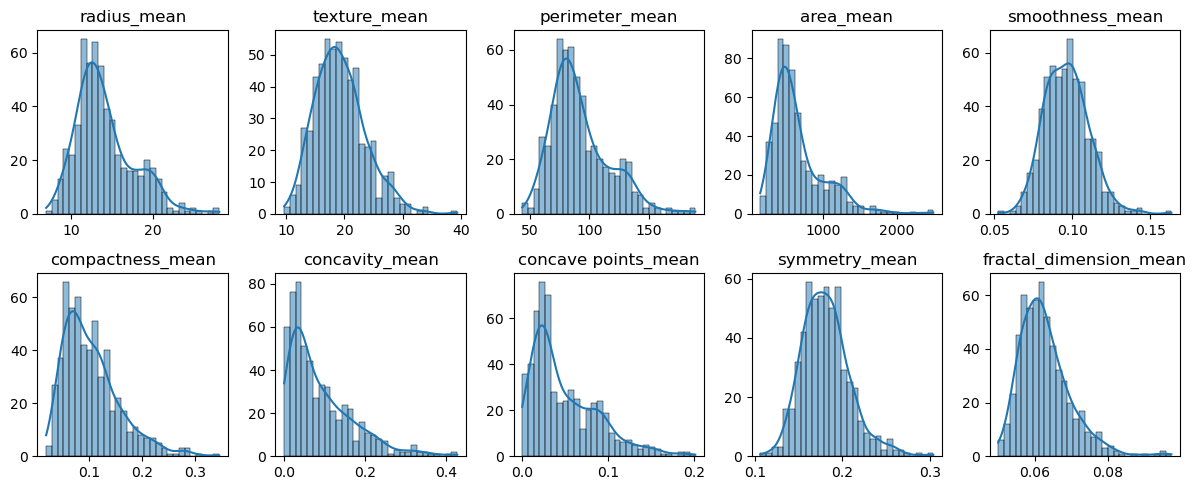

In [14]:
# Grid size settings
num_features = len(mean_features)
cols = 5  # Number of columns per row
rows = math.ceil(num_features / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 5))
axes = axes.flatten()

for idx, feature in enumerate(mean_features):
    sns.histplot(data[feature], kde=True, bins=30, ax=axes[idx])
    axes[idx].set_title(feature)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

# Hide unused axes if any
for idx in range(num_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


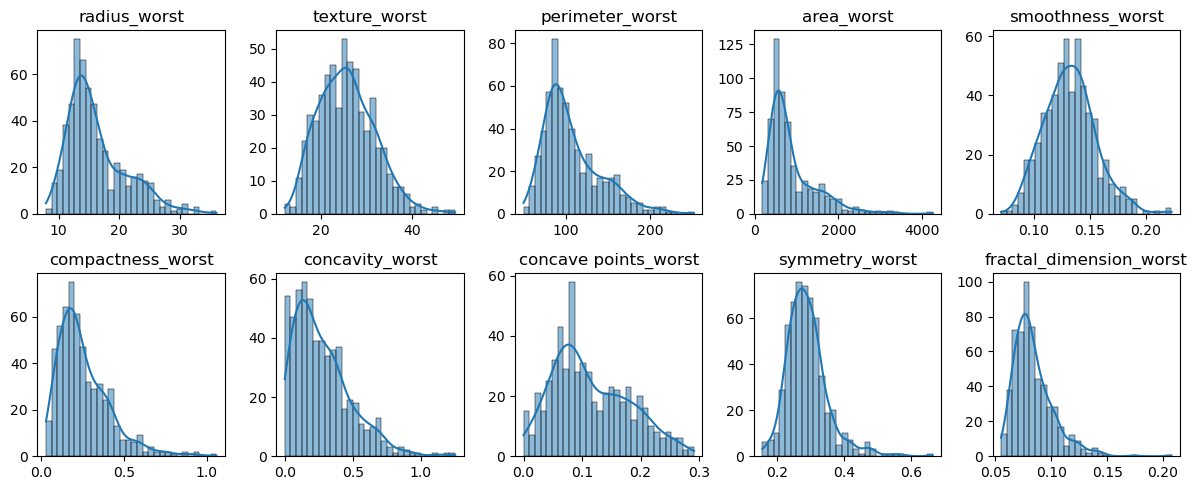

In [15]:
# Grid size settings
num_features = len(worst_features)
cols = 5  # Number of columns per row
rows = math.ceil(num_features / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 5))
axes = axes.flatten()

for idx, feature in enumerate(worst_features):
    sns.histplot(data[feature], kde=True, bins=30, ax=axes[idx])
    axes[idx].set_title(feature)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

# Hide unused axes if any
for idx in range(num_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


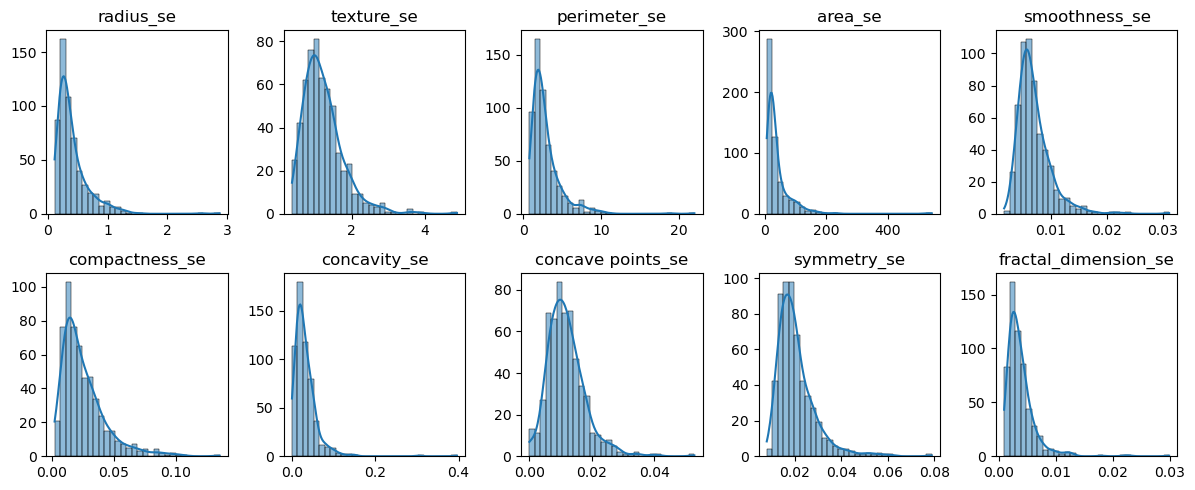

In [16]:
# Grid size settings
num_features = len(se_features)
cols = 5  # Number of columns per row
rows = math.ceil(num_features / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 5))
axes = axes.flatten()

for idx, feature in enumerate(se_features):
    sns.histplot(data[feature], kde=True, bins=30, ax=axes[idx])
    axes[idx].set_title(feature)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

# Hide unused axes if any
for idx in range(num_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


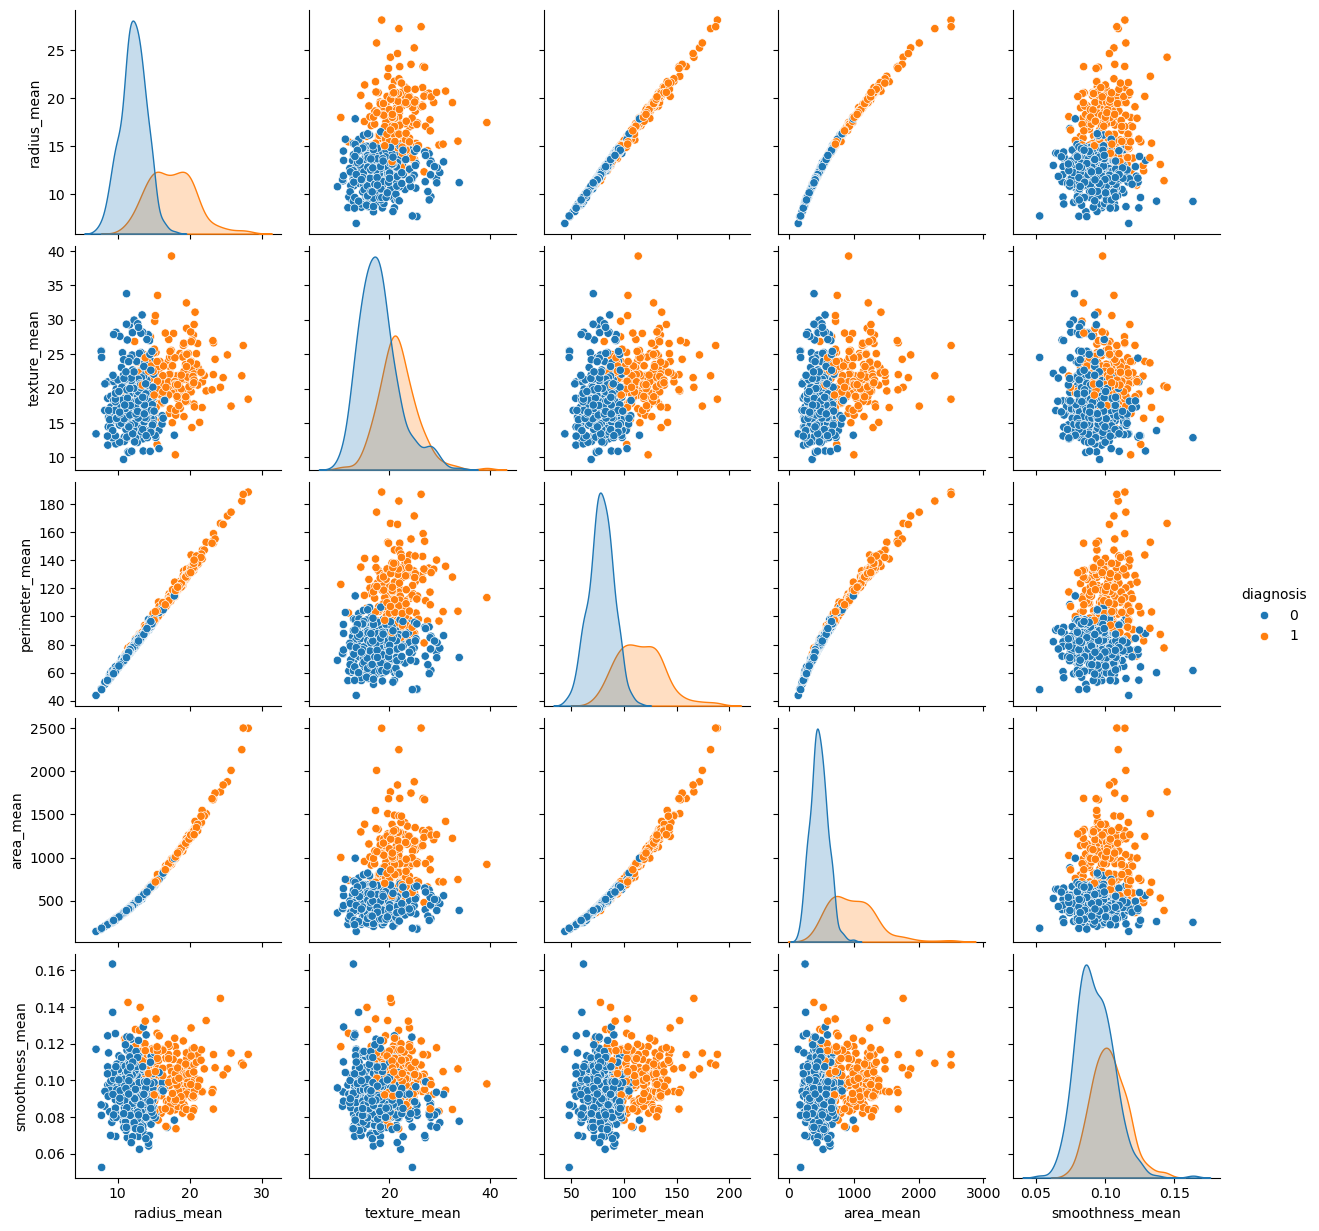

In [17]:
# For performance, limit to a subset of features
subset_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'diagnosis']

sns.pairplot(data[subset_features], hue='diagnosis')
plt.show()

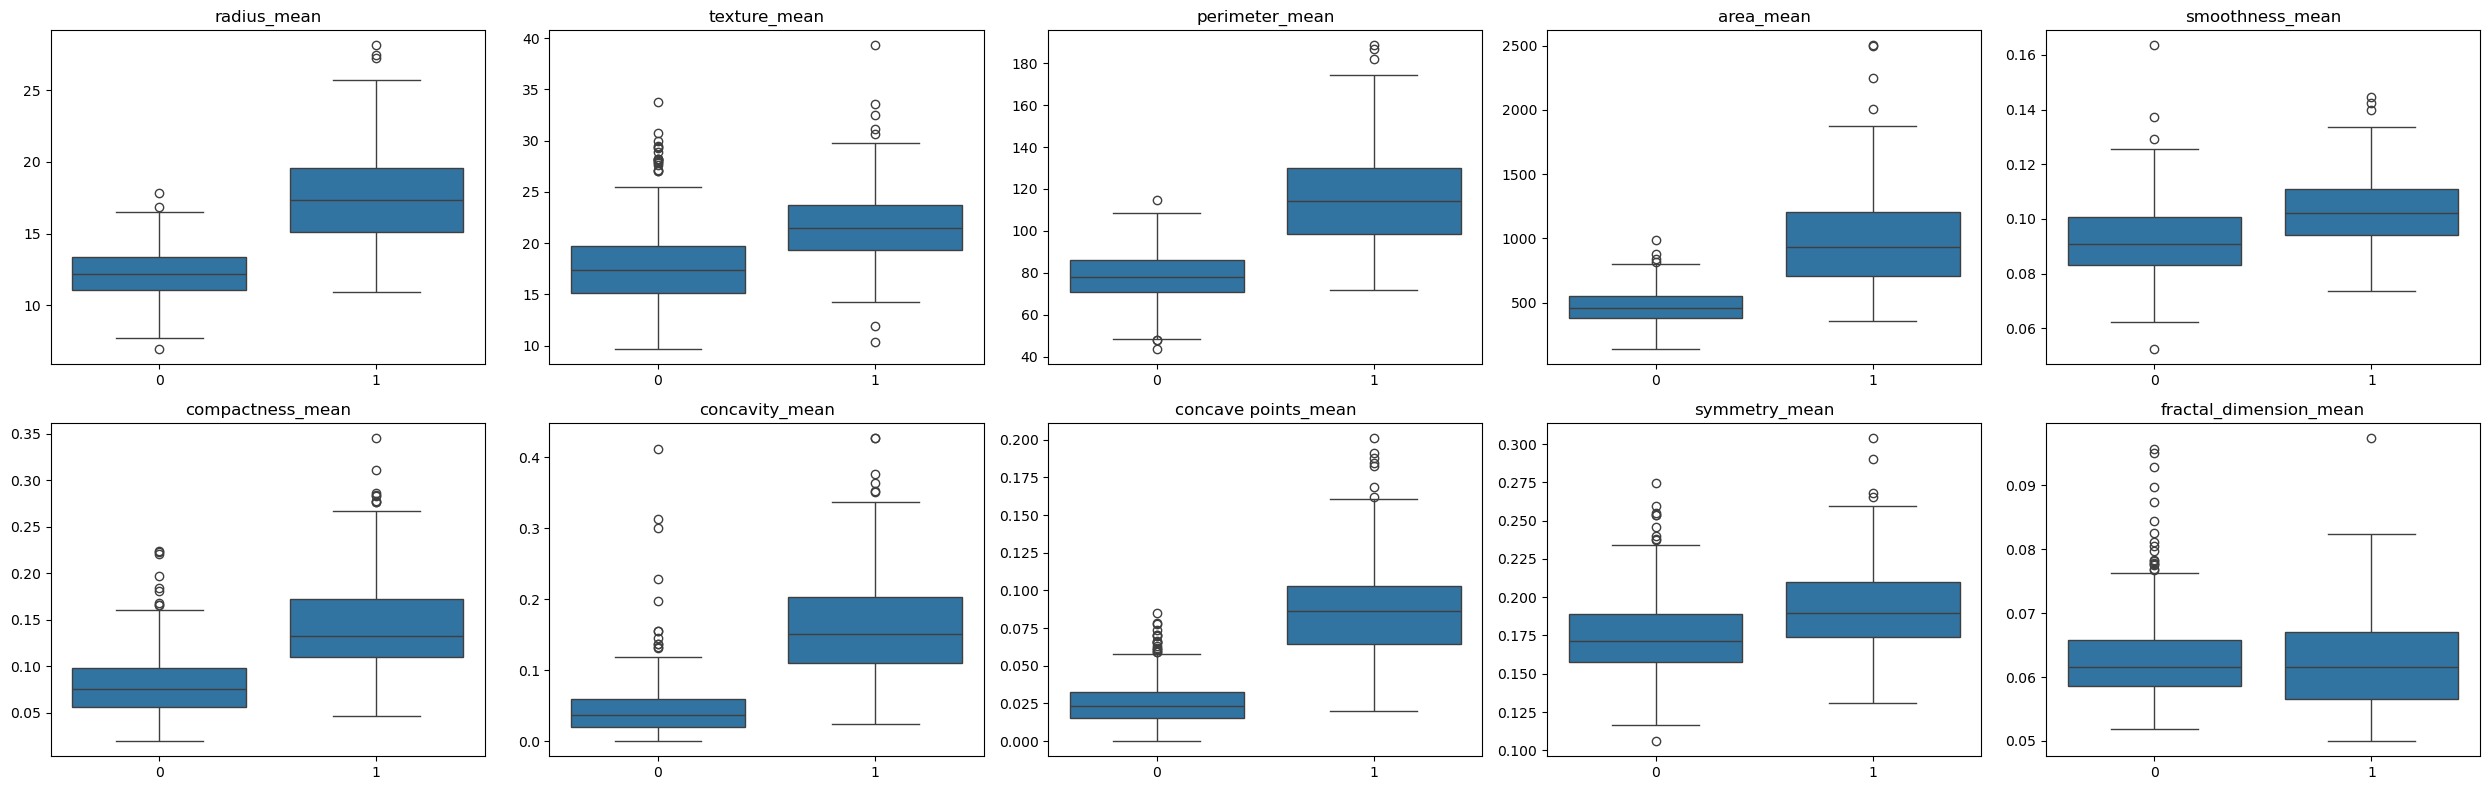

In [18]:
# List of features, excluding 'id' and 'diagnosis'
feature_columns = [col for col in mean_features if col not in ['id', 'diagnosis']]

# Grid settings
n_cols = 5  # number of columns you want in the grid
n_rows = (len(feature_columns) + n_cols - 1) // n_cols  # calculate required rows

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten the axes for easy indexing

# Plot each feature in its subplot
for i, feature in enumerate(feature_columns):
    sns.boxplot(x='diagnosis', y=feature, data=data, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')  # optional: remove x-axis label
    axes[i].set_ylabel('')  # optional: remove y-axis label

# Hide any unused subplots if features < grid size
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

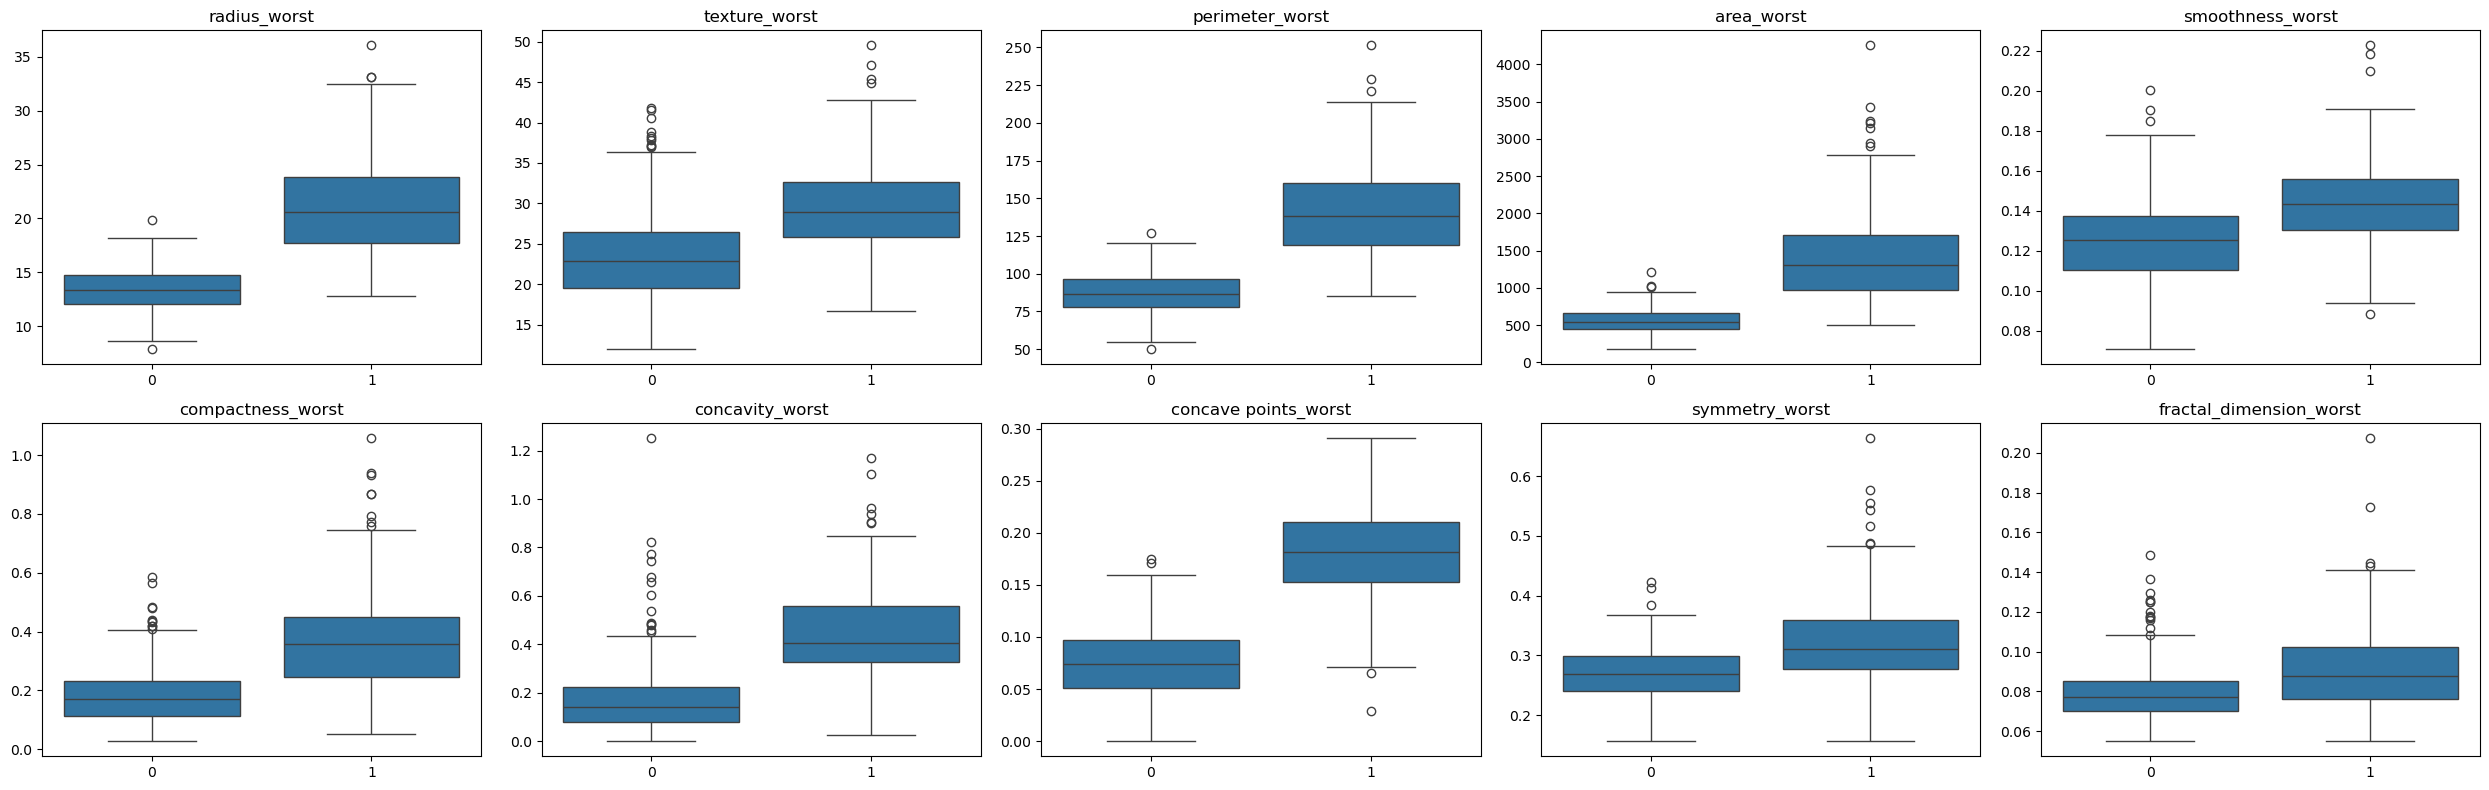

In [19]:
# List of features, excluding 'id' and 'diagnosis'
feature_columns = [col for col in worst_features if col not in ['id', 'diagnosis']]

# Grid settings
n_cols = 5  # number of columns you want in the grid
n_rows = (len(feature_columns) + n_cols - 1) // n_cols  # calculate required rows

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten the axes for easy indexing

# Plot each feature in its subplot
for i, feature in enumerate(feature_columns):
    sns.boxplot(x='diagnosis', y=feature, data=data, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')  # optional: remove x-axis label
    axes[i].set_ylabel('')  # optional: remove y-axis label

# Hide any unused subplots if features < grid size
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

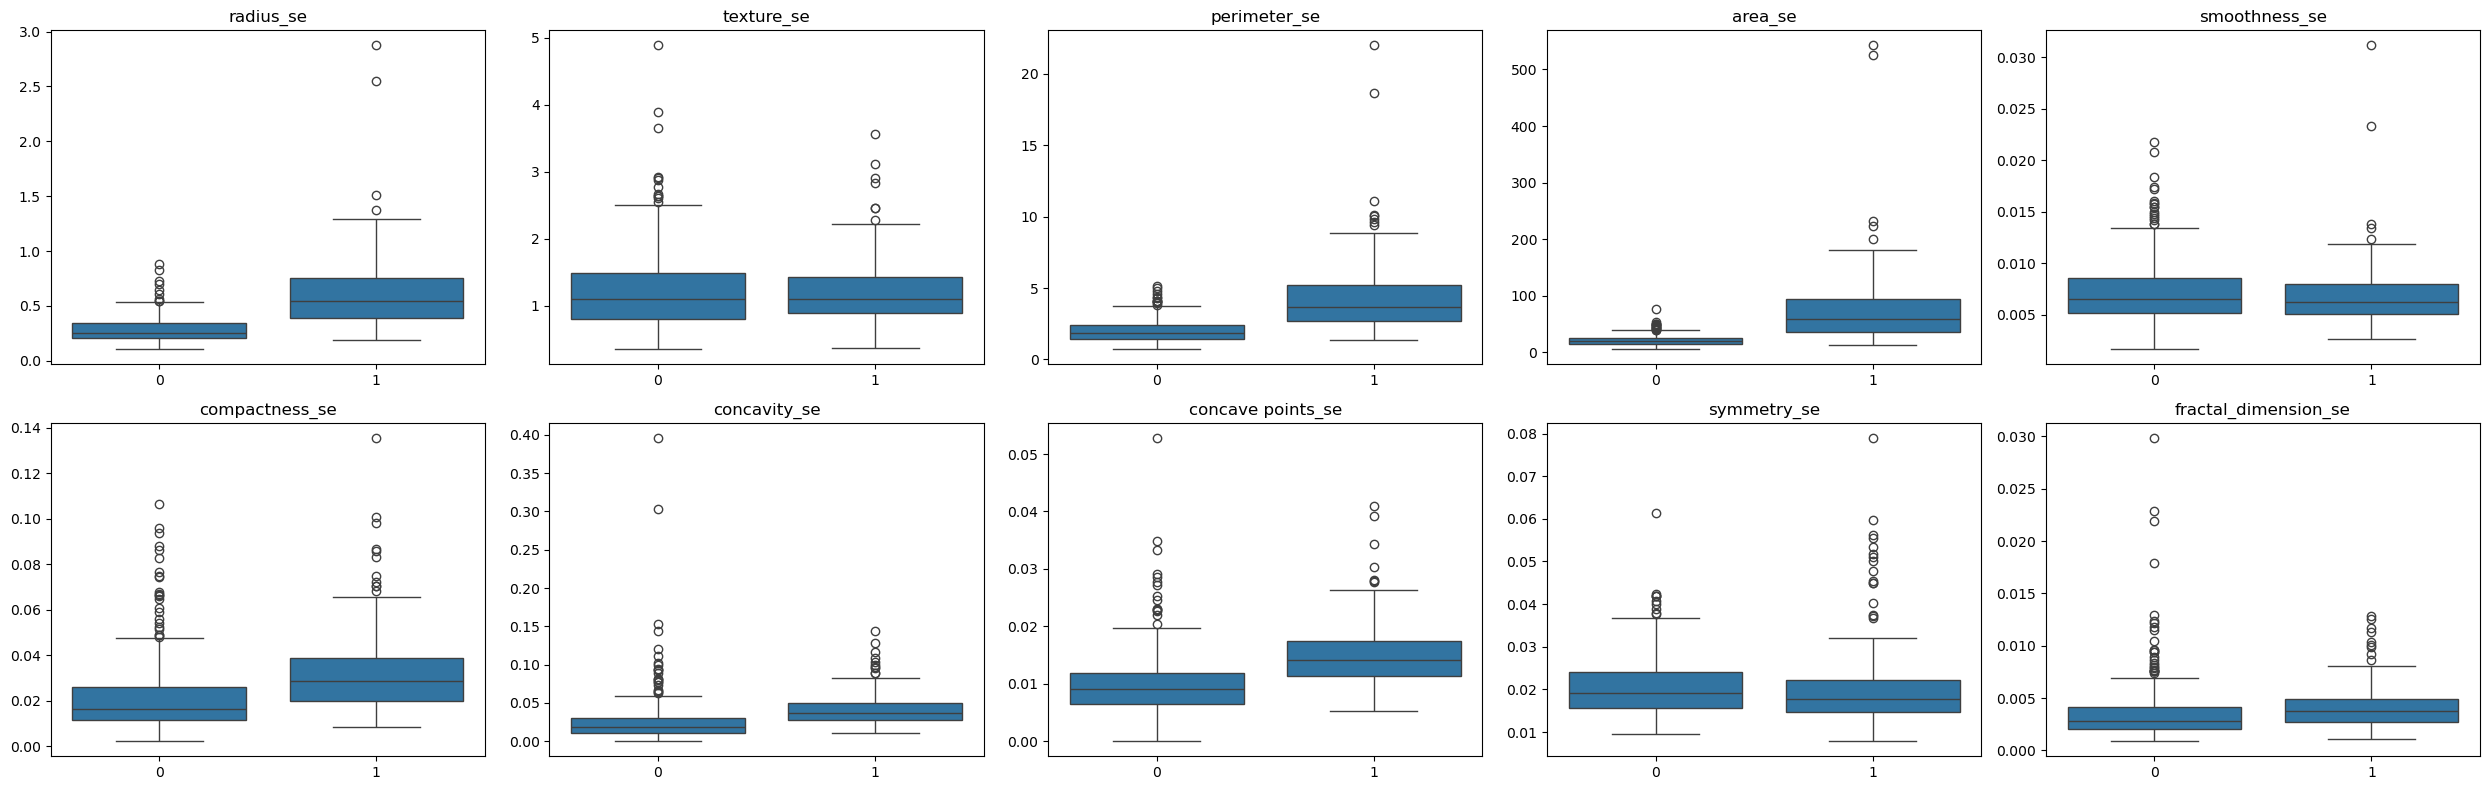

In [20]:
# List of features, excluding 'id' and 'diagnosis'
feature_columns = [col for col in se_features if col not in ['id', 'diagnosis']]

# Grid settings
n_cols = 5  # number of columns you want in the grid
n_rows = (len(feature_columns) + n_cols - 1) // n_cols  # calculate required rows

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten the axes for easy indexing

# Plot each feature in its subplot
for i, feature in enumerate(feature_columns):
    sns.boxplot(x='diagnosis', y=feature, data=data, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')  # optional: remove x-axis label
    axes[i].set_ylabel('')  # optional: remove y-axis label

# Hide any unused subplots if features < grid size
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Building Classification Models

In [21]:
data = data.drop(["area_mean", "area_se","area_worst"], axis=1)
x = data.drop("diagnosis", axis=1)
y = data["diagnosis"]
x.head()

,radius_mean,texture_mean,perimeter_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,...,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,...,0.006193,25.38,17.33,184.60,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,...,0.003532,24.99,23.41,158.80,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,...,0.004571,23.57,25.53,152.50,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,...,0.009208,14.91,26.50,98.87,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,...,0.005115,22.54,16.67,152.20,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [22]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [23]:
# ============================
# Outlier Removal
# ============================

# IQR Method
Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1
mask_iqr = ~((x < (Q1 - 1.5 * IQR)) | (x > (Q3 + 1.5 * IQR))).any(axis=1)
x_iqr = x[mask_iqr]
y_iqr = y[mask_iqr]
# x, y = x_iqr, y_iqr  # Uncomment to apply IQR filtering

# Z-Score Method
z_scores = np.abs(zscore(x))
mask_z = (z_scores < 3).all(axis=1)
x_zscore = x[mask_z]
y_zscore = y[mask_z]
# x, y = x_zscore, y_zscore  # Uncomment to apply Z-Score filtering

# Winsorization
x_winsor = x.apply(lambda col: mstats.winsorize(col, limits=(0.01, 0.01)), axis=0)
# x = pd.DataFrame(x_winsor, columns=x.columns)  # Uncomment to apply Winsorization


# ============================
# Scaling
# ============================

# Standard Scaler
scaler_standard = StandardScaler()
x_standard_scaled = pd.DataFrame(scaler_standard.fit_transform(x), columns=x.columns)
x = x_standard_scaled  # Uncomment to apply Standard Scaling

# Min-Max Scaler
scaler_minmax = MinMaxScaler()
x_minmax_scaled = pd.DataFrame(scaler_minmax.fit_transform(x), columns=x.columns)
# x = x_minmax_scaled  # Uncomment to apply Min-Max Scaling

# Robust Scaler
scaler_robust = RobustScaler()
x_robust_scaled = pd.DataFrame(scaler_robust.fit_transform(x), columns=x.columns)
# x = x_robust_scaled  # Uncomment to apply Robust Scaling

# ============================
# Feature Selection / Reduction
# ============================

# SelectKBest
skb = SelectKBest(score_func=f_classif, k=20)
x_skb = pd.DataFrame(skb.fit_transform(x, y))
# x = x_skb  # Uncomment to apply SelectKBest

# RFE
rfe_model = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=rfe_model, n_features_to_select=10)
x_rfe = pd.DataFrame(rfe.fit_transform(x, y))
# x = x_rfe  # Uncomment to apply RFE

# PCA
pca = PCA(n_components=5)
x_pca = pd.DataFrame(pca.fit_transform(x))
# x = x_pca  # Uncomment to apply PCA

# ============================
# Class Imbalance Handling
# ============================

# SMOTE (Oversampling)
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x, y)
x, y = x_smote, y_smote  # Uncomment to apply SMOTE

# Random Undersampling
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x, y)
# x, y = x_rus, y_rus  # Uncomment to apply Random Undersampling

# ============================
# Final Output
# ============================

print("Preprocessing steps loaded.")
print("Uncomment the `x = ...` and `y = ...` lines to apply a specific step.")

Preprocessing steps loaded.
Uncomment the `x = ...` and `y = ...` lines to apply a specific step.


## Machine Learning Models

In [24]:
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

# Split data as specified by the user
print("\n--- Splitting Data ---")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=60)
print(f"Training data shape: x_train={x_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: x_test={x_test.shape}, y_test={y_test.shape}")
print("-" * 50)


# D. Model Definitions and Parameter Grids for GridSearchCV
print("\n--- D. Model Definitions and Parameter Grids ---")

# Define models and their parameter grids for GridSearchCV
models_and_param_grids = [
    {
        "type": "Logistic Regression",
        "model": LogisticRegression(random_state=60),
        "param_grid": {
            "C": [0.01, 0.1,1, 10,100],
            "penalty": ["l2","l1"],
            "solver": ["lbfgs", "liblinear"],
            "max_iter": [1000]
        }
    },
    {
        "type": "Random Forest",
        "model": RandomForestClassifier(random_state=60),
        "param_grid": {
            "n_estimators": [10,100, 200, 300,400,500],
            "max_depth": [5, 10, 20,100,500],
            "criterion": ["gini", "entropy","log_loss"]
        }
    },
    {
        "type": "SVM",
        "model": SVC(probability=True, random_state=20),
        "param_grid": {
            "C": [0.1, 0.5,1, 10],
            "kernel": ["rbf", "linear","sigmoid"],
            "gamma": ["scale", "auto"]
        }
    },
    {
        "type": "Gradient Boosting",
        "model": GradientBoostingClassifier(random_state=60),
        "param_grid": {
            "n_estimators": [50, 100, 200, 300],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 8],

        }
    },
    {
        "type": "K-Nearest Neighbors",
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [1, 3, 5, 7, 15, 20],
            "weights": ["uniform", "distance"],
            "algorithm": ["auto", "ball_tree", "kd_tree","brute"]
        }
    },
    {
        "type": "Naive Bayes",
        "model": GaussianNB(),
        "param_grid": {
            "var_smoothing": [1e-10,1e-9, 1e-8, 1e-7]
        }
    },
    {
        "type": "XGBoost",
        "model": XGBClassifier(random_state=60, eval_metric="logloss", objective="binary:logistic"),
        "param_grid": {
            "n_estimators": [50, 100, 200, 300],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 6, 10],
            "xgb_subsample": [0.6, 1],
            "xgb_colsample": [0.6, 1],
            "xgb_gamma": [0.0, 0.2, 0.4]

        }
    },
    {
        "type": "LightGBM",
        "model": LGBMClassifier(random_state=60, objective="binary", verbose=-1),
        "param_grid": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.1, 0.2],
            "num_leaves": [20, 31, 40],
            "enable_categorical": [True] # Keep this if you have categorical features
        }
    },
]

print(f"Models configured for comparison and hyperparameter tuning: {[m['type'] for m in models_and_param_grids]}")
print("-" * 50)

# E. Execution and Comparison Loop with GridSearchCV
print("\n--- E. Model Training and Comparison with Hyperparameter Tuning ---")

results_summary = [] # To store key metrics for overall comparison
best_models_summary = [] # To store best parameters and their accuracy

# Lists to store data for plotting
roc_plot_data = []
cm_plot_data = []

# Loop through each model and its parameter grid
for model_config in models_and_param_grids:
    model_type = model_config['type']
    model_instance = model_config['model']
    param_grid = model_config['param_grid']

    print(f"\nEvaluating Model: {model_type}")

    try:
        # Define StratifiedKFold for cross-validation
        cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=60)

        # Perform GridSearchCV
        grid_search = GridSearchCV(estimator=model_instance,
                                   param_grid=param_grid,
                                   cv=cv_stratified,
                                   scoring='accuracy',
                                   n_jobs=-1, # Use all available cores
                                   verbose=1)

        print(f"  Performing GridSearchCV for {model_type}...")
        grid_search.fit(x_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score_cv = grid_search.best_score_

        print(f"  Best Parameters for {model_type}: {best_params}")
        print(f"  Best 3-Fold CV Accuracy for {model_type}: {best_score_cv:.3f}")

        # Train the best model on the full training data
        best_model.fit(x_train, y_train)
        y_pred = best_model.predict(x_test)

        print("\n  Classification Report (Test Set):")
        print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

        # ROC Curve and AUC Data Collection
        y_scores = None
        final_estimator_for_proba = best_model
        if isinstance(best_model, Pipeline):
            final_estimator_for_proba = best_model.named_steps['classifier']

        if hasattr(final_estimator_for_proba, "predict_proba"):
            y_scores = best_model.predict_proba(x_test)[:, 1]
        elif hasattr(final_estimator_for_proba, "decision_function"):
            y_scores = best_model.decision_function(x_test)
        else:
            print("  Warning: Neither predict_proba nor decision_function available for ROC. ROC AUC will be 0.")

        if y_scores is not None and not np.all(y_scores == 0):
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)
            print(f"  ROC AUC (Test Set): {roc_auc:.3f}")
            roc_plot_data.append({'model_type': model_type, 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc})
        else:
            roc_auc = 0.0
            print("  ROC AUC: N/A (Cannot calculate without probabilities or decision function)")
            roc_plot_data.append({'model_type': model_type, 'fpr': None, 'tpr': None, 'roc_auc': 0.0})

        # Confusion Matrix Data Collection
        cm = confusion_matrix(y_test, y_pred)
        cm_plot_data.append({'model_type': model_type, 'cm': cm})


        # Append results to summaries
        results_summary.append({
            'Model': model_type,
            'Accuracy (Test Set)': np.mean(y_pred == y_test) if len(y_test) > 0 else np.nan,
            'Precision (Malignant)': classification_report(y_test, y_pred, output_dict=True, target_names=['Benign', 'Malignant'])['Malignant']['precision'],
            'Recall (Malignant)': classification_report(y_test, y_pred, output_dict=True, target_names=['Benign', 'Malignant'])['Malignant']['recall'],
            'F1-Score (Malignant)': classification_report(y_test, y_pred, output_dict=True, target_names=['Benign', 'Malignant'])['Malignant']['f1-score'],
            'ROC AUC': roc_auc,
            'CV Accuracy (Mean)': best_score_cv
        })

        best_models_summary.append({
            'Model': model_type,
            'Best Parameters': best_params,
            '3-Fold CV Accuracy': best_score_cv
        })

    except Exception as e:
        print(f"  An error occurred during GridSearchCV or evaluation for {model_type}: {e}")
        print(f"  Details: {e}")
        results_summary.append({
            'Model': model_type,
            'Accuracy (Test Set)': np.nan,
            'Precision (Malignant)': np.nan,
            'Recall (Malignant)': np.nan,
            'F1-Score (Malignant)': np.nan,
            'ROC AUC': np.nan,
            'CV Accuracy (Mean)': np.nan
        })
        best_models_summary.append({
            'Model': model_type,
            'Best Parameters': "Error",
            '3-Fold CV Accuracy': np.nan
        })
        roc_plot_data.append({'model_type': model_type, 'fpr': None, 'tpr': None, 'roc_auc': np.nan})
        cm_plot_data.append({'model_type': model_type, 'cm': None})
    print("-" * 50)

# F. Overall Results Summary
print("\n--- F. Overall Results Summary ---")
summary_df = pd.DataFrame(results_summary)
# Order columns for better readability
summary_df = summary_df[['Model', 'Accuracy (Test Set)', 'CV Accuracy (Mean)', 'Precision (Malignant)', 'Recall (Malignant)', 'F1-Score (Malignant)', 'ROC AUC']]
print(summary_df.sort_values(by='CV Accuracy (Mean)', ascending=False).to_string())

print("\nComparison and hyperparameter tuning complete.")


Libraries loaded successfully!

--- Splitting Data ---
Training data shape: x_train=(606, 27), y_train=(606,)
Testing data shape: x_test=(108, 27), y_test=(108,)
--------------------------------------------------

--- D. Model Definitions and Parameter Grids ---
Models configured for comparison and hyperparameter tuning: ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'K-Nearest Neighbors', 'Naive Bayes', 'XGBoost', 'LightGBM']
--------------------------------------------------

--- E. Model Training and Comparison with Hyperparameter Tuning ---

Evaluating Model: Logistic Regression
  Performing GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  Best Parameters for Logistic Regression: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
  Best 3-Fold CV Accuracy for Logistic Regression: 0.982

  Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign 


--- H. ROC Curves for All Models ---


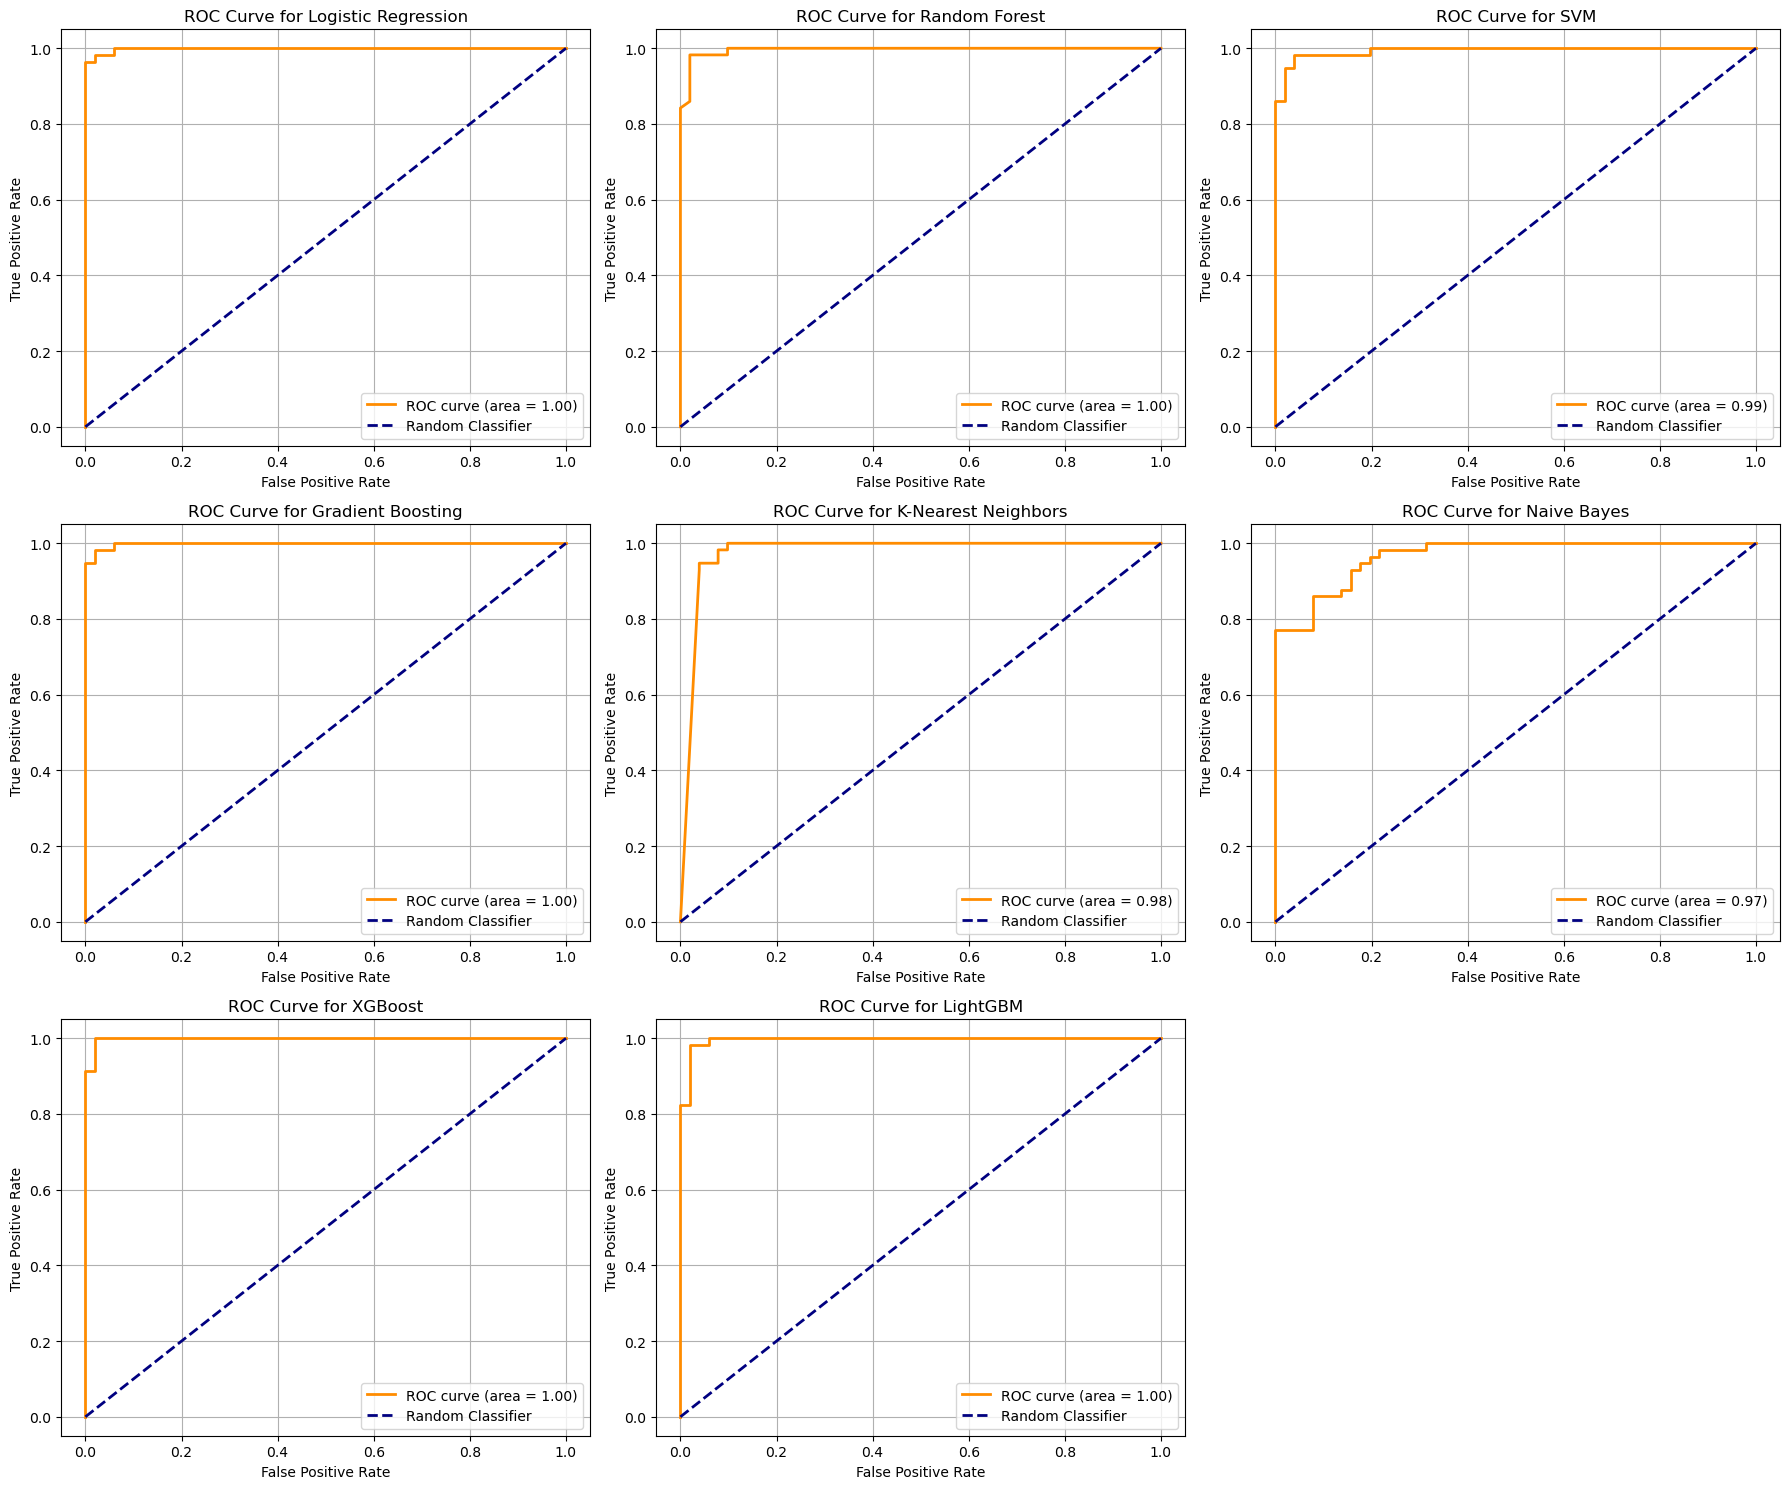

In [25]:
# H. Visualizing Model Performance: ROC Curves and Confusion Matrices
num_models = len(models_and_param_grids) # Get the number of models
num_cols_roc = 3 # Number of columns for ROC plots
num_rows_roc = (num_models + num_cols_roc - 1) // num_cols_roc # Calculate rows needed

# Plotting ROC Curves in a Grid
print("\n--- H. ROC Curves for All Models ---")
plt.figure(figsize=(num_cols_roc * 6, num_rows_roc * 5)) # Adjust figure size dynamically

for i, roc_data in enumerate(roc_plot_data):
    model_type = roc_data['model_type']
    fpr = roc_data['fpr']
    tpr = roc_data['tpr']
    roc_auc = roc_data['roc_auc']

    ax = plt.subplot(num_rows_roc, num_cols_roc, i + 1) # Create subplot

    if fpr is not None and tpr is not None and roc_auc is not None:
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for {model_type}')
        ax.legend(loc="lower right")
        ax.grid(True)
    else:
        ax.text(0.5, 0.5, f'ROC Not Available for {model_type}', horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes, fontsize=12, color='red')
        ax.set_title(f'ROC Curve for {model_type}')
        ax.axis('off') # Turn off axes for models where ROC couldn't be calculated

plt.tight_layout()
plt.show()


--- H. Confusion Matrices for All Models ---


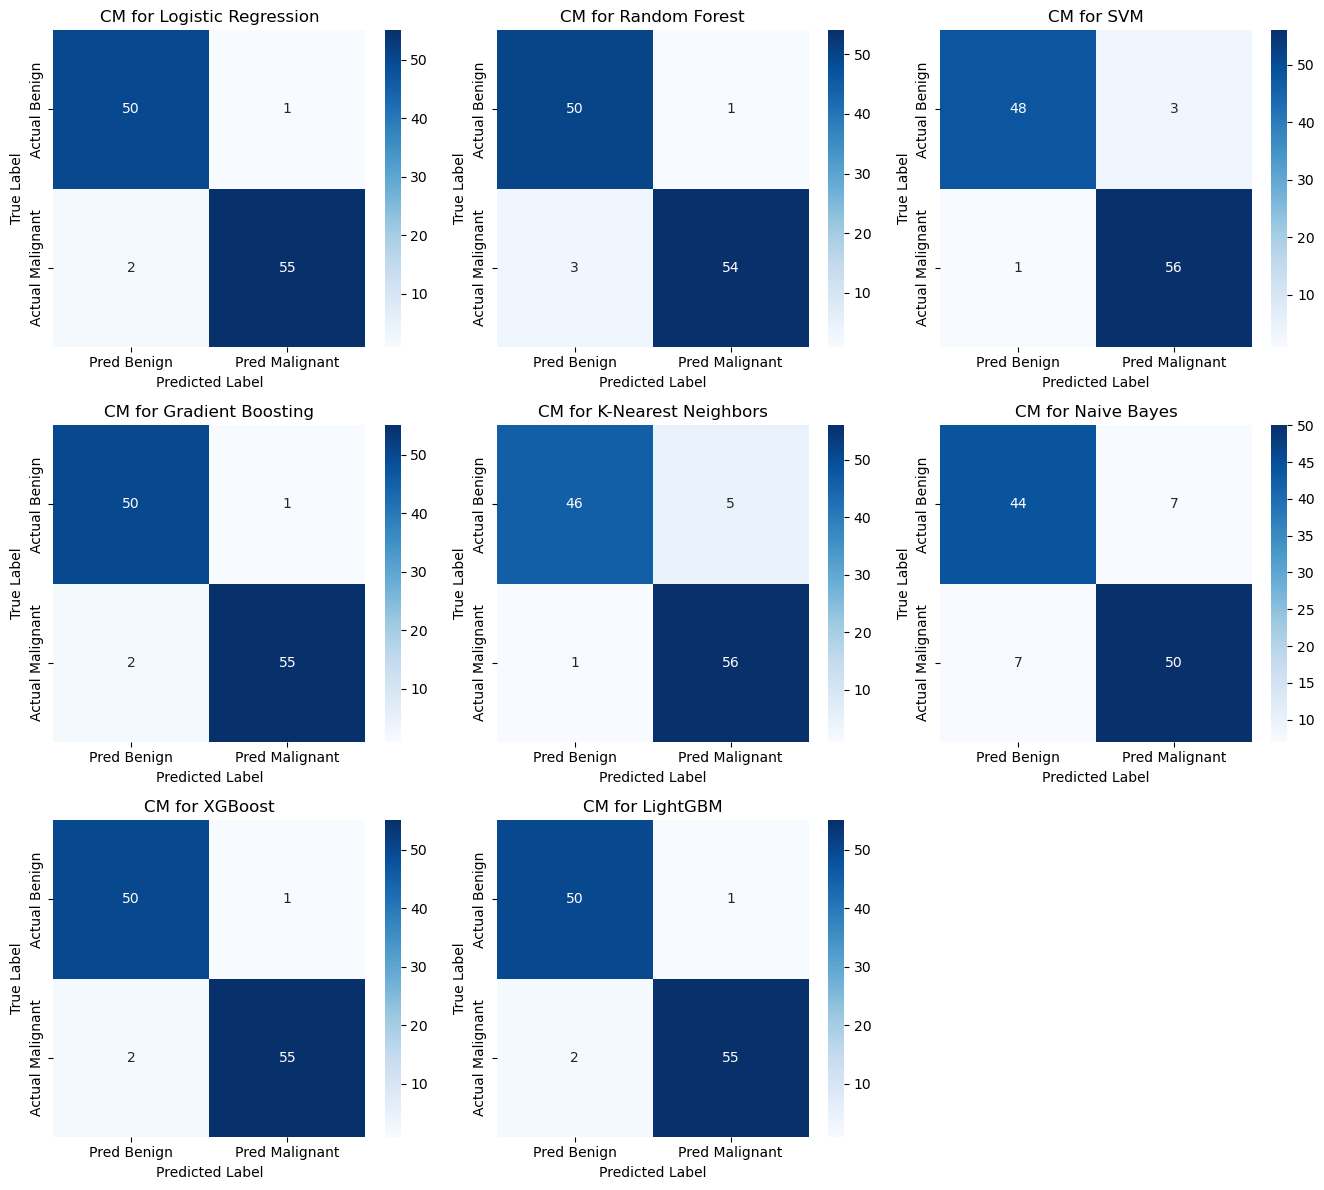

In [26]:
# Plotting Confusion Matrices in a Grid
print("\n--- H. Confusion Matrices for All Models ---")

num_cols_cm = 3 # Number of columns for CM plots
num_rows_cm = (num_models + num_cols_cm - 1) // num_cols_cm # Calculate rows needed

plt.figure(figsize=(num_cols_cm * 4.5, num_rows_cm * 4)) # Adjust figure size dynamically

for i, roc_data in enumerate(cm_plot_data):
    model_type = roc_data['model_type']
    cm = roc_data['cm']

    ax = plt.subplot(num_rows_cm, num_cols_cm, i + 1) # Create subplot

    if cm is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Pred Benign', 'Pred Malignant'],
                    yticklabels=['Actual Benign', 'Actual Malignant'], ax=ax)
        ax.set_title(f'CM for {model_type}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    else:
        ax.text(0.5, 0.5, f'CM Not Available for {model_type}', horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes, fontsize=12, color='red')
        ax.set_title(f'CM for {model_type}')
        ax.axis('off') # Turn off axes for models where CM couldn't be calculated

plt.tight_layout()
plt.show()

In [27]:
pd.set_option('display.max_colwidth', 0)

print("\n--- G. Best Parameters and 3-Fold CV Accuracy for Each Model ---")
best_params_df = pd.DataFrame(best_models_summary)
best_params_df.sort_values(by='3-Fold CV Accuracy', ascending=False)


--- G. Best Parameters and 3-Fold CV Accuracy for Each Model ---


,Model,Best Parameters,3-Fold CV Accuracy
2,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.983498
0,Logistic Regression,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}",0.981848
4,K-Nearest Neighbors,"{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}",0.981848
7,LightGBM,"{'enable_categorical': True, 'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 20}",0.980198
3,Gradient Boosting,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}",0.973597
1,Random Forest,"{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}",0.971947
6,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'xgb_colsample': 0.6, 'xgb_gamma': 0.0, 'xgb_subsample': 0.6}",0.971947
5,Naive Bayes,{'var_smoothing': 1e-10},0.932343


## Deep Learning (Neural Network) Model

In [28]:
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

print("\n--- Splitting Data ---")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=60)
print(f"Training data shape: x_train={x_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: x_test={x_test.shape}, y_test={y_test.shape}")
print("-" * 50)

print("\n--- D. Deep Learning Model Definition ---")

def create_fixed_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

dl_model = KerasClassifier(
    model=create_fixed_nn_model,
    model__input_dim=x_train.shape[1],
    epochs=100,
    batch_size=32,
    verbose=0,
    random_state=60
)

fixed_params = {
    'optimizer': 'adam',
    'learning_rate': 0.001,
    'activation': 'relu',
    'dropout_rate': 0.2,
    'neurons_layer1': 64,
    'neurons_layer2': 32,
    'epochs': 100,
    'batch_size': 32
}

print("Deep Learning model configured with fixed parameters.")
print("-" * 50)

print("\n--- E. Model Training and Evaluation ---")

roc_plot_data = []
cm_plot_data = []

model_type = "Deep Learning (Neural Network)"

try:
    print(f"\nTraining Model: {model_type}...")
    dl_model.fit(x_train, y_train)
    
    y_pred = dl_model.predict(x_test)

    print("\n  Classification Report (Test Set):")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

    y_scores = dl_model.predict_proba(x_test)[:, 1]
    if y_scores is not None and not np.all(y_scores == 0):
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        print(f"  ROC AUC (Test Set): {roc_auc:.3f}")
        roc_plot_data.append({'model_type': model_type, 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc})
    else:
        roc_auc = 0.0
        print("  ROC AUC: N/A (Cannot calculate without probabilities or decision function)")
        roc_plot_data.append({'model_type': model_type, 'fpr': None, 'tpr': None, 'roc_auc': 0.0})

    cm = confusion_matrix(y_test, y_pred)
    cm_plot_data.append({'model_type': model_type, 'cm': cm})

except Exception as e:
    print(f"  An error occurred during training or evaluation for {model_type}: {e}")
    print(f"  Details: {e}")
    roc_plot_data.append({'model_type': model_type, 'fpr': None, 'tpr': None, 'roc_auc': np.nan})
    cm_plot_data.append({'model_type': model_type, 'cm': None})

print("-" * 50)

print("\n--- F. Deep Learning Model Parameters ---")
print("The model was trained with the following fixed parameters:")
for param, value in fixed_params.items():
    print(f"  {param}: {value}")
print("-" * 50)

print("\nDeep Learning model training and evaluation complete.")

Libraries loaded successfully!

--- Splitting Data ---
Training data shape: x_train=(606, 27), y_train=(606,)
Testing data shape: x_test=(108, 27), y_test=(108,)
--------------------------------------------------

--- D. Deep Learning Model Definition ---
Deep Learning model configured with fixed parameters.
--------------------------------------------------

--- E. Model Training and Evaluation ---

Training Model: Deep Learning (Neural Network)...

  Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign       0.98      0.98      0.98        51
   Malignant       0.98      0.98      0.98        57

    accuracy                           0.98       108
   macro avg       0.98      0.98      0.98       108
weighted avg       0.98      0.98      0.98       108

  ROC AUC (Test Set): 0.998
--------------------------------------------------

--- F. Deep Learning Model Parameters ---
The model was trained with the following fixed parameters:
 


--- H. ROC Curve for Deep Learning Model ---


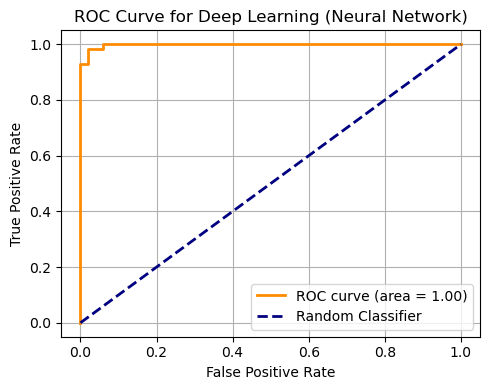


--- H. Confusion Matrix for Deep Learning Model ---


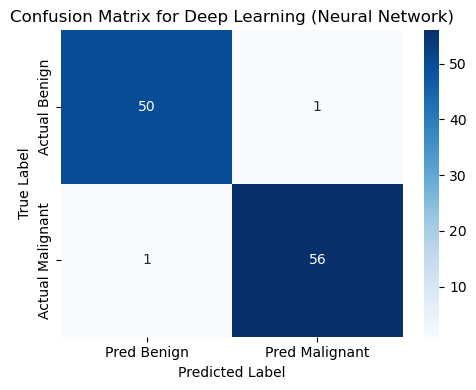

In [29]:

print("\n--- H. ROC Curve for Deep Learning Model ---")
plt.figure(figsize=(5, 4))

if roc_plot_data:
    roc_data = roc_plot_data[0]
    model_type = roc_data['model_type']
    fpr = roc_data['fpr']
    tpr = roc_data['tpr']
    roc_auc = roc_data['roc_auc']

    if fpr is not None and tpr is not None and not np.isnan(roc_auc):
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_type}')
        plt.legend(loc="lower right")
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, f'ROC Not Available for {model_type}', horizontalalignment='center',
                verticalalignment='center', transform=plt.gca().transAxes, fontsize=14, color='red')
        plt.title(f'ROC Curve for {model_type}')
        plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- H. Confusion Matrix for Deep Learning Model ---")
plt.figure(figsize=(5, 4))

if cm_plot_data:
    roc_data = cm_plot_data[0]
    model_type = roc_data['model_type']
    cm = roc_data['cm']

    if cm is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Pred Benign', 'Pred Malignant'],
                    yticklabels=['Actual Benign', 'Actual Malignant'])
        plt.title(f'Confusion Matrix for {model_type}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
    else:
        plt.text(0.5, 0.5, f'CM Not Available for {model_type}', horizontalalignment='center',
                verticalalignment='center', transform=plt.gca().transAxes, fontsize=14, color='red')
        plt.title(f'Confusion Matrix for {model_type}')
        plt.axis('off')

plt.tight_layout()
plt.show()